## Motivational Shapley Value Experiment (Appendix A)

Run this notebook to recreate the figure in Appendix A.

This is an example showing that the recovery property is not satisfied for SHAP explanations.

To this end, we train transformers and a fully connected model on a simple toy dataset and then compute SHAP explanations for different sequences of the same word.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

Training commands: Train models with the following command:
```
.scripts/train_models_linear.sh
```

In [3]:
import torch
from experiment_utils.transformer_models import DistilBert, GPT2, Bert
from transformers import AutoTokenizer

In [8]:
def compute_logits_for_single_token(model, tokenizer, n_max=10, use_cls=True, input_str="perfect", use_device="cuda:2"):
    logit_results = []
    cls_tok = torch.tensor([101])
    input_tok = torch.tensor(tokenizer.convert_tokens_to_ids(input_str)).reshape(1)
    sep_tok = torch.tensor([102])
    with torch.no_grad():
        x = input_tok
        for i in range(n_max):
            #print(x)
            if use_cls:
                input = torch.cat((cls_tok, x, sep_tok))
            else:
                input =x
            logit_score = model(input.reshape(1,-1).to(use_device))["logits"]
            logit_results.append(logit_score.detach().cpu())
            x = torch.cat((x, input_tok), dim=0)
        
    return torch.stack(logit_results)

### 2 layers

In [10]:
prefix_path= "/mnt/ssd3/tobias/models_lin_bin_rerun" # Path were the train script stored the output
run_ids = ["sparsebow_bert_2_r0.pt", "sparsebow_gpt2_2_r0.pt"] ## insert run_ids here.
use_device = "cuda:1" # set to an available device

model_list, tok_list = [], []
for run in run_ids:
    s_dict = torch.load(f"{prefix_path}/{run}")
    # extract num_layers, num_heads
    parts = run.split("_")
    n_heads = 12
    n_layers = int(parts[-2])
    if "gpt2" in run:
        model_obj = GPT2(n_layer=n_layers, n_head=n_heads)
        tokenizer = AutoTokenizer.from_pretrained('distilgpt2', use_fast=True)
    else:
        if "distilbert" in run:
            model_obj = DistilBert(n_layers=n_layers, n_heads=n_heads)
        else:
            model_obj = Bert(n_layers=n_layers, n_heads=n_heads)
        tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
    model_obj.model.load_state_dict(s_dict)
    for p in model_obj.model.parameters():
        p.requires_grad_(False)
        
    model_trained = model_obj.model.to(use_device).eval()
    model_list.append(model_trained)
    tok_list.append(tokenizer)

/tmp/ipykernel_3513016/2423015765.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_dict = torch.load(f"{prefix_path}/{run}")
Some weights of BertForSequenceClassificati

We now iteratively pass sequences containing the word perfect one or several times to the model, e.g., \["perfect"\], \["perfect", "perfect"\]

tensor([0.5247], device='cuda:1')
tensor([0.5176], device='cuda:1')


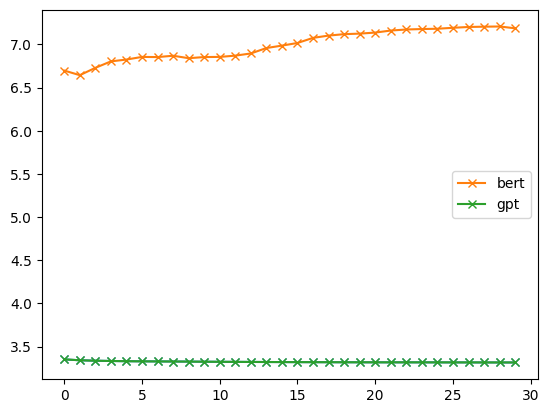

In [12]:
import matplotlib.pyplot as plt
input_str="perfect",
for r, run in enumerate(run_ids):
    if "bert" in run:
        cls_tok = torch.tensor([101, 102])
        base_logit = model_obj.model(cls_tok.reshape(1,-1).to(use_device))["logits"]
        base_logit = base_logit[:,1]-base_logit[:,0]
        print(base_logit)
        w_cls = compute_logits_for_single_token(model_list[r], tok_list[r], n_max=30, use_cls=True, use_device=use_device, input_str=input_str)
        w_cls = w_cls[:,:,1]-w_cls[:,:,0]
        plt.plot(w_cls, "-x")
    else: # GPT
        neutral_tok = torch.tensor(tok_list[r].convert_tokens_to_ids("the"))
        #print(neutral_tok)
        base_logit = model_obj.model(neutral_tok.reshape(1,-1).to(use_device))["logits"]
        base_logit = base_logit[:,1]-base_logit[:,0]
        print(base_logit)
        wo_cls = compute_logits_for_single_token(model_list[r], tok_list[r], n_max=30, use_cls=False,  use_device=use_device, input_str=input_str)
        wo_cls = wo_cls[:,:,1]-wo_cls[:,:,0]
        lin = torch.arange(30)*(wo_cls[0]-base_logit.cpu())+base_logit.cpu()
plt.plot(wo_cls, "-x", label="bert")
plt.plot(w_cls, "-x", label="gpt")
#plt.plot(torch.arange(30)-1,lin, "--x", c="k", label="linear")
plt.legend()

The transformer models fail to capture the linear relationship and the output is almost constant and independent of sequence length.

## Train a fixed context fully connected model on the sparse BOW

For comparison, we train a fully connected model.

In [13]:
## Load the same dataset as in the main code an train model.
from experiment_utils.bow_dataset import SparseBoWDataset

In [14]:
words_dict = {"the": (0.2, 0.0), "we": (0.2, 0.0), "movie": (0.2, 0.0), "watch": (0.2, 0.0),
      "best": (0.06, 1.0), "perfect": (0.06, 1.5), "good": (0.08, 0.7),
      "worst": (0.06, -1.5), "poor": (0.06, -1.0),"ok": (0.08, -0.7)}

In [15]:
import torch.nn as nn
class TwoLayerFixedContext(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        return self.layer2(x)

In [55]:
## Train the linear model using BERT embeddings
## Create wrapper
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification

# We use distilbert embeddings as inputs and provide this function to get the pretrained embeddings for input seqs
model_obj = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased").to(use_device)
import typing as tp
def compute_embeddings(input_ids: torch.Tensor, input_positions: tp.Union[torch.Tensor, int]):
    """ Compute distilbert embeddings (copied from the hugginface distilbert code) """
    if type(input_positions) == int:
        input_positions = torch.ones(input_ids.shape, dtype=torch.long)*input_positions
    elif input_positions.numel() == 1:
        input_positions = torch.ones(input_ids.shape, dtype=torch.long)*input_positions
    input_positions = input_positions.to(use_device)
    embed = model_obj.distilbert.embeddings
    position_embeddings = embed.position_embeddings(input_positions)
    inputs_embeds = embed.word_embeddings(input_ids) + position_embeddings
    inputs_embeds = embed.LayerNorm(inputs_embeds)
    return inputs_embeds


distil_tok = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", use_fast=True)

myds = SparseBoWDataset(distil_tok, all_words_dict =  words_dict)
mydl = DataLoader(myds, batch_size=32)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
from torch.optim import Adam

def fit_sgd(my_dl, model, num_eps=10, lr=5e-4, batch_size=32):
    model = model.to(use_device)
    my_optim = Adam(model.parameters(), lr = lr)
    losses = []
    iters = 0
    loss_fn = nn.CrossEntropyLoss()
    for ep in range(num_eps):
        losses = []
        for batch in my_dl:
            my_optim.zero_grad()
            input_embs = compute_embeddings(batch["input_ids"].to(use_device), 1)
            #print(input_embs.shape)
            output = model.forward(input_embs.reshape(len(input_embs), -1))
            loss = loss_fn(output, batch["label"].to(use_device))
            loss.backward()
            my_optim.step()
            losses.append(loss.item())
            iters += 1
        print(torch.tensor([losses]).mean())
    return model

In [57]:
fc_model = TwoLayerFixedContext(32*768, 400)

In [58]:
fit_sgd(mydl, fc_model, num_eps=20)

tensor(0.6028)
tensor(0.4159)
tensor(0.3921)
tensor(0.3755)
tensor(0.3787)
tensor(0.3712)
tensor(0.3704)
tensor(0.3697)
tensor(0.3611)
tensor(0.3515)
tensor(0.3635)
tensor(0.3448)
tensor(0.3690)
tensor(0.3671)
tensor(0.3587)
tensor(0.3433)
tensor(0.3523)
tensor(0.3581)
tensor(0.3528)
tensor(0.3671)


TwoLayerFixedContext(
  (layer1): Linear(in_features=24576, out_features=400, bias=True)
  (layer2): Linear(in_features=400, out_features=2, bias=True)
)

In [59]:
def compute_logits_for_single_token_fc(model, n_max=10, use_cls=True):
    """ Compute the logits for the sequences for the FC model. """
    logit_results = []
    cls_tok = torch.tensor([101])
    input_tok = torch.tensor([3819])
    pad_tok = torch.tensor([1996])
    inputs_pad = torch.ones(n_max+1, 32, dtype=torch.long)*pad_tok
    if use_cls:
        x = cls_tok.reshape(1)
    else:
        x = torch.empty(0)
    
    for i in range(n_max+1):
        inputs_pad[i, :len(x)] = x
        x = torch.cat((x, input_tok), dim=0)
    inputs_pad[:,-1] = 102
    #print(inputs_pad)
    with torch.no_grad():
        input_embs = compute_embeddings(inputs_pad.to(use_device), 1)
        logit_score = model.forward(input_embs.reshape(len(input_embs), -1))
        score = logit_score[:,1]-logit_score[:,0]
    return score

In [60]:
res = compute_logits_for_single_token_fc(fc_model)

In [61]:
res

tensor([0.6704, 1.8781, 3.1048, 3.9276, 4.8128, 5.6536, 6.4772, 7.2428, 7.9644,
        8.7037, 9.4114], device='cuda:1')

**Plot sequence lengths over logits**

Text(0, 0.5, 'logit score')

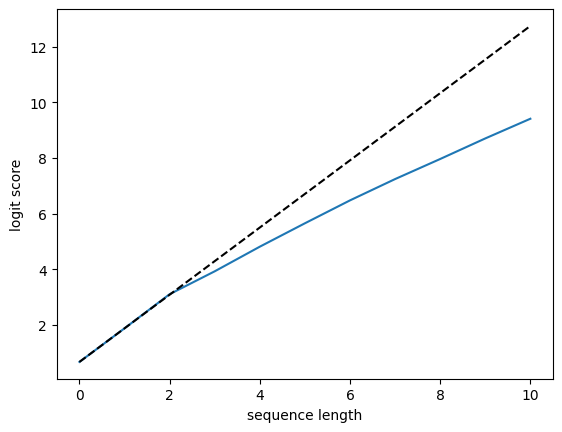

In [64]:
import matplotlib.pyplot as plt
res = res.cpu()
plt.plot(res)
plt.plot(torch.arange(len(res))*(res[1]-res[0])+res[0], "--k")
plt.xlabel("sequence length")
plt.ylabel("logit score")

## Calculate shapley values for this case.

In [66]:
from experiment_utils.attribution_methods import ShapleyValues

In [69]:
shap_lists_runs = []
for k, r in enumerate(run_ids):
    myShap = ShapleyValues(model_list[k], tok_list[k], method="kernel", num_samples = 500, impute_token="the", device=use_device)
    use_cls = ("bert" in r)
    relevant_token = "perfect"
    shap_list = []
    cls_tok = torch.tensor([101])
    sep_tok = torch.tensor([102])
    input_tok = torch.tensor(tok_list[k].convert_tokens_to_ids(relevant_token)).reshape(1)
    if use_cls:
        x = torch.cat((cls_tok, input_tok), dim=0)
    else:
        x = input_tok
        
    for i in range(20):
        print(i)
        if use_cls:
            x_sep =  torch.cat((x, sep_tok), dim=0)
        else:
            x_sep = x
        #print(x_sep)
        shapley = myShap.get_signed_importance_for_tokens([i.item() for i in x_sep.flatten()])
        #print(shapley)
        shap_list.append(torch.tensor(shapley))
        x = torch.cat((x, input_tok), dim=0)
    shap_lists_runs.append(shap_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


## Compute SHAP values for the linear model

In [75]:
## Wrapper for linear model to compute shap values
class LinWrapper:
    def __init__(self, mymodel):
        self.model = mymodel
        self.device = use_device
        
    def __call__(self, inputs):
        # pad to full length
        input_pad = torch.ones(len(inputs), 32, dtype=torch.long)*1996
        input_pad[:, 1:inputs.shape[1]+1] = inputs
        input_pad[:, 0] = 101
        input_pad[:, -1] = 102
        #print(input_pad)
        input_embs = compute_embeddings(input_pad.to(self.use_device), 1)
        logit_score = self.model.forward(input_embs.reshape(len(input_embs), -1))
        return {"logits": logit_score}

In [76]:
lin_model_wrapper = LinWrapper(fc_model)

In [77]:
myShaplin = ShapleyValues(lin_model_wrapper, tokenizer, method="kernel", num_samples = 500, impute_token="the")
use_cls=False
shap_list_lin = []
cls_tok = torch.tensor([101])
input_tok = torch.tensor([3819])
if use_cls:
    x = torch.cat((cls_tok, input_tok), dim=0)
else:
    x = input_tok
for i in range(20):
    print(i)
    #logit_results = []
    shapley = myShaplin.get_signed_importance_for_tokens([i.item() for i in x.flatten()])
    #print(shapley)
    shap_list_lin.append(torch.tensor(shapley))
    x = torch.cat((x, input_tok), dim=0)

0
Provided model function fails when applied to the provided data set.


AttributeError: 'LinWrapper' object has no attribute 'use_device'

In [205]:
shap_list_bert, shap_list_gpt = shap_lists_runs[0], shap_lists_runs[1]

In [229]:
shap_list_bert[4]

tensor([ 0.4813,  0.4511,  0.4536,  0.4323,  0.4473,  0.3881, -0.0037],
       dtype=torch.float64)

In [207]:
my_matrix = torch.ones(20, 20)*float("nan")
my_matrix_lin = torch.zeros(20,20)*float("nan")
my_matrix_exp = torch.zeros(20, 20)*float("nan")
my_matrix_gpt = torch.zeros(20, 20)*float("nan")

for i in range(10):
    print(i)
    my_matrix[i, :len(shap_list_bert[i])-2] = shap_list_bert[i][1:-1]
    my_matrix_lin[i, :len(shap_list_lin[i])] = shap_list_lin[i]
    my_matrix_gpt[i, :len(shap_list_lin[i])] = shap_list_gpt[i]
    my_matrix_exp[i, :i+1] = 1.5

0
1
2
3
4
5
6
7
8
9


In [208]:
torch.save((my_matrix, my_matrix_lin, my_matrix_gpt, my_matrix_exp), "figures/mat_motivation.pt")

In [209]:
import torch
my_matrix, my_matrix_lin, my_matrix_gpt, my_matrix_exp = torch.load("figures/mat_motivation.pt")

In [210]:
import matplotlib.pyplot as plt

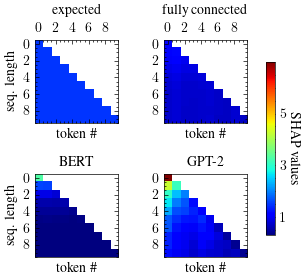

In [227]:
plt.style.use('./figures/matplot.mplstyle')
plt.rc('axes', titlesize=10) 
f, ax = plt.subplots(2, 2)
ax = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]
sub_sz = 10
vmax = 7 #None #5
vmin = 0.3 #None # 0.5
ax[0].matshow(my_matrix_exp[:sub_sz, :sub_sz], cmap = "jet", vmax=vmax, vmin=vmin)
ax[0].set_title("expected")
ax[1].matshow(my_matrix_lin[:sub_sz, :sub_sz], cmap = "jet", vmax=vmax, vmin=vmin)
ax[1].set_title("fully connected")
ax[2].matshow(my_matrix[:sub_sz, :sub_sz], cmap = "jet", vmax=vmax, vmin=vmin)
ax[2].set_title("BERT")
pcs = ax[3].matshow(my_matrix_gpt[:sub_sz, :sub_sz], cmap = "jet", vmax=vmax, vmin=vmin)
ax[3].set_title("GPT-2")
for a in ax:
    a.set_xlabel("token \#")
    a.grid([])
ax[2].set_xticks([])
ax[3].set_xticks([])
ax[0].set_ylabel("seq. length")
ax[2].set_ylabel("seq. length")
f.set_size_inches(3.28,3)
plt.tight_layout()
cbar = f.colorbar(pcs, ax=[ax[1], ax[3]], shrink=0.8, pad=0.15)
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.get_yaxis().set_ticks([1.0,3.0, 5])
cbar.set_label('SHAP values', rotation=270)
f.savefig("figures/figure_motivation.pdf")